In [1]:
import pickle
import torch
import numpy as np
import collections
import torch.optim as optim 
from utils import get_topwords, plot_fig
from plsv_vae import PlsvVAE
from sklearn.feature_extraction.text import CountVectorizer

In [2]:

with open('data/reuters/preprossed_data.pkl', 'rb') as f: 
    preprossed_data = pickle.load(f)

with open('data/reuters/data_reuters_labels.pkl', 'rb') as f:
    train_label = pickle.load(f)

vectorizer = CountVectorizer(min_df=9)
train_vec = vectorizer.fit_transform(preprossed_data).toarray()
vocab = vectorizer.vocabulary_
nonzeros_indexes = np.where(train_vec.any(1))[0]
train_vec_non_zeros = [train_vec[i] for i in nonzeros_indexes]


train_vec = np.array(train_vec_non_zeros)
print(len(train_vec))
print(len(train_label))
print(len(vocab))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor_train_w = torch.from_numpy(np.array(train_vec)).float()
train_label = np.asarray(train_label)

id_vocab = dict(map(reversed, vocab.items()))
num_coordinate = 2
bs = 256
en1_units_x = 100
en2_units_x = 100
num_input = train_vec[0].shape[0]
variance_x = 1
learning_rate = 0.002
beta1 = 0.99
beta2 = 0.999
drop_rate = 0.6
num_topic = 50

7674
7674
3062


## Train

In [3]:
model = PlsvVAE(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs, "inverse_quadratic")
model.to(device)
optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2))
epochs = 100
phi_arr = []
beta_arr = []
x_arr = []
recon_arr = []
list_d = []
all_indices = torch.randperm(tensor_train_w.size(0)).split(bs)

for epoch in range(epochs):

    loss_u_epoch = 0.0
    loss_xkl_epoch = 0.0
    loss_betakl_epoch = 0.0
    loss_phikl_epoch = 0.0
    loss_KLD = 0.0
    loss_phi_epoch = 0.0
    recon_ep = 0.0
    loss_epoch = 0.0
    model.train()
    d_temp = []

    for batch_ndx in all_indices:

        input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        input_c = None
        recon_v, (loss, loss_u, kl) = model(input_w, compute_loss=True)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()             # backpror.step()            # update parameters
        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_KLD += kl.item() #/ len(tensor_train_w)) 
        recon_ep += recon_v.mean().item() 

    x_arr.append(loss_xkl_epoch)
    recon_arr.append(loss_u_epoch)

    if epoch % 10 == 0:
        print('Epoch {}, loss={}'.format(epoch, loss_epoch))
        print('recon_loss={}, KLD= {}'.format(loss_u_epoch, loss_KLD)) 

Epoch 0, loss=14065.298278808594
recon_loss=14020.089172363281, KLD= 45.209100127220154
Epoch 10, loss=11654.037109375
recon_loss=11609.332641601562, KLD= 44.70440065860748
Epoch 20, loss=11488.502990722656
recon_loss=11409.448974609375, KLD= 79.05403780937195
Epoch 30, loss=11384.679229736328
recon_loss=11295.86264038086, KLD= 88.81655383110046
Epoch 40, loss=11298.057220458984
recon_loss=11202.185607910156, KLD= 95.8715889453888
Epoch 50, loss=11232.00765991211
recon_loss=11131.818572998047, KLD= 100.18906092643738
Epoch 60, loss=11180.706085205078
recon_loss=11075.068786621094, KLD= 105.63731265068054
Epoch 70, loss=11139.796447753906
recon_loss=11029.631042480469, KLD= 110.16536021232605
Epoch 80, loss=11112.511108398438
recon_loss=10997.857391357422, KLD= 114.65373706817627
Epoch 90, loss=11097.930877685547
recon_loss=10979.079193115234, KLD= 118.85172986984253


## Test beta and visualization

In [4]:
model.eval()
x_list = []
phi_list = []
beta_list = []
labels_list = []
with torch.no_grad():
    for batch_ndx in all_indices:
        input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        labels_list.extend(labels)
        z, recon_v, zx, zx_phi = model(input_w, compute_loss=False)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()
        x_list.extend(zx)

    x_list = np.array(x_list)

    beta = model.decoder.weight.data.cpu().numpy().T#
    zphi = model.decoder_phi_bn(model.centres).data.cpu().numpy()
    print("---"*10)
    topword_topics = get_topwords(beta, id_vocab)
    for topwords in topword_topics:
        print(topwords)
    print("---"*10)


------------------------------
0: said reuter acquir inc unit complet sell agreement buy subject
1: billion stg profit tax franc dividend pre turnov interest group
2: said japan unit talk agreement would import last state reuter
3: said stock compani common save first approv feder vote board
4: share said pct reuter dlr stock inc cyclop fund approv
5: oil product price said barrel reuter crude petroleum field energi
6: bank rate billion point month market pct cut dealer interest
7: said market dollar foreign exchang currenc interest central year treasuri
8: said trade countri would japan minist econom economi deficit world
9: trade said export japanes offici ec reagan market hous congress
10: ct loss year gain exclud includ discontinu mln per credit
11: said reuter corp bank unit term compani inc save system
12: mln pretax extraordinari cent debit int gain loss disposit dilut
13: loss oper shr net share corp respect yr sale pension
14: said reuter union trade foreign new week futur gov

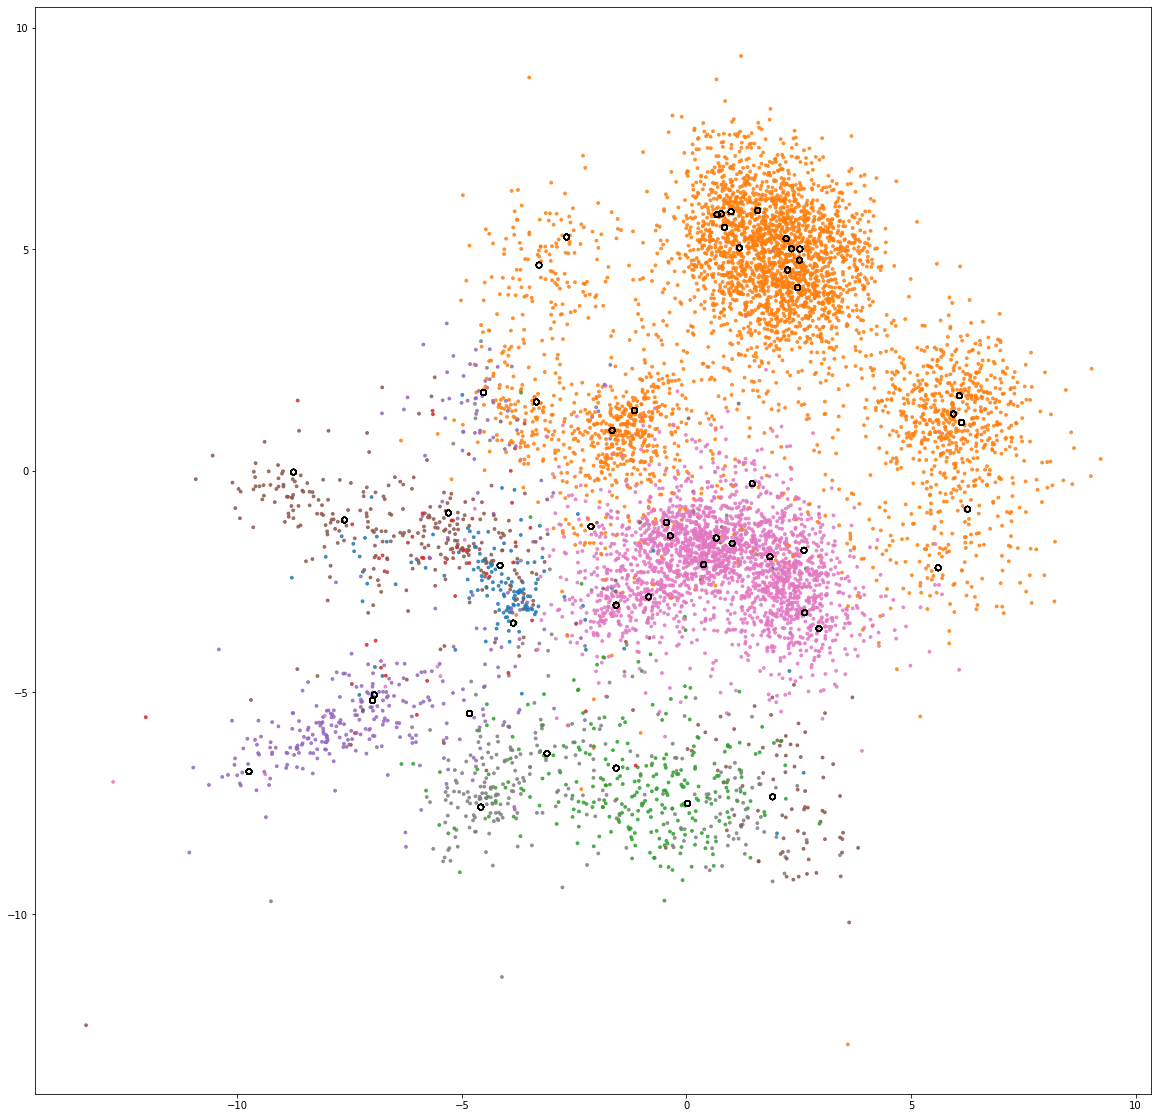

In [5]:
categories = {'ship': 'C0',
             'earn': 'C1',
             'interest': 'C2',
             'grain': 'C3',
             'trade': 'C4',
             'crude': 'C5',
             'acq': 'C6',
             'money-fx': 'C7'}
plot_fig(x_list, labels_list, categories, zphi)